<a href="https://colab.research.google.com/github/WKorga/DataMining2019/blob/master/MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#System rekomendujący

Poniższy algorytm ma pełnić rolę systemu rekomendującego filmy użytkownikom, na podstawie analizy danych dotyczących m.in. ocen wystawionych przez użytkowników, gatunków oraz tagów przypisanych poszczególnym filmom.

##Opis danych
Rekomendacje oparte zostaną na zbiorze danych [MovieLens 25M](https://grouplens.org/datasets/movielens/)

W jego skład wchodzą m.in. następujące pliki z danymi:
- **ratings.csv**- około 25 milionów rekordów, zawierających informację o tym jak dany użytkownik ocenił dany film, wraz z timestampem 
- **movies.csv** - lista wszystkich filmów, która przydziela poszczególnym tytułom unikalne ID oraz zawiera informację o gatunku każdego z filmów
- **tags.csv** - lista rekordów zawierających informację o tagu jakim dany użytkownik oznaczył dany film




#Opis metody

Algorytm oparty zostanie na wektorach cech poszczególnych filmów.

Na podstawie informacji zawartych w plikach tags.csv i movies.csv, dla każdego filmu można stworzyć wektor w pewnej n-wymiarowej przestrzeni opisujący jego typ, gatunek inne kategorie jakie przydzielili mu użytkownicy.

Ideą algorytmu jest polecanie użytkownikowi filmów podobnych do tych, które mu się podobały, na podstawie odległości wektorów dla poszczególnych filmów. 

Uproszczony opis działania:
1. Wczytaj filmy wysoko ocenione przez użytkownika
2. Znajdź filmy leżące jak najbliżej wysoko ocenionych w przestrzeni wektorów cech
3. Zwróć n najlepszych wyników (np. kierując się kryterium najmniejszej odległości) 

#Importy i wczytywanie danych

In [0]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets
import csv as csv
import sklearn.decomposition
import sklearn.svm
from sklearn.decomposition import PCA

sns.set_style('whitegrid')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

In [0]:
tags_df = pd.read_csv("/content/mydrive/dataMining/movie_lens/tags.csv")
ratings_df = pd.read_csv("/content/mydrive/dataMining/movie_lens/ratings.csv")
movies_df = pd.read_csv("/content/mydrive/dataMining/movie_lens/movies.csv")

#Tworzenie wektorów dla filmów
Gatunki z movies.csv oraz tagi nadane przez użytkowników zostaną potraktowane równorzędnie.

Na podstawie danych o tagach i gatunkach, dla każdego filmu zostanie obliczony N-wymiatowy wektor (gdzie N to liczba tagów) zawierający informację o tym jak bardzo dany film pasuje do danego tagu.

Następnie, w celu zmniejszenia wymiarowości danych, wektory zostaną zredukowane za pomoca algorytmu PCA.

##Wyciąganie gatunków z movies.csv

In [0]:
movies_df['genres']= movies_df['genres'].str.split('|')
movies_df_ex = movies_df.explode('genres')[['movieId','genres']]
movies_df_ex = movies_df_ex.rename(columns={'genres':'tag'})
movies_df_ex['tag'] = movies_df_ex['tag'].str.lower()

##Filtrowanie tagów
Dane o tagach mogą zawierać sporo błędów w rodzaju literówek lub nieprawidłowych pisowni, więc zostaną one przefiltrowane pod kątem minimalnej ilości wystąpień

In [0]:
tags_df_f = tags_df[['movieId','tag']]
tags_df_f['tag'] = tags_df_f['tag'].str.lower()
tags, tag_count = np.unique(tags_df_f['tag'].astype(str), return_counts=True)
tags = tags[tag_count>50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
tags_df_f = tags_df_f[np.isin(tags_df_f['tag'],tags)]

##Wektory
Z połączonych danych o tagach i gatunkach zostaną stworzone wektory cech dla każdego z filmów

Wektor tworzony jest na podstawie ilości oznaczeń filmu danym tagiem.

Jeśli film został oznaczony 5 razem tagiem A, 3 razy tagiem B i 0 razy tagiem C, to jego wektor będzie miał postać:
<center>[5 , 3 , 0]</center>

Następnie zostanie on znormalizowany, za pomocą dzielenia przez największą liczbę:

<center>[1 , 0.6 , 0]</center>


Filmy w zbiorze są wybrane losowo z prawdziwych danych, więc ID nie zachowują ciągłości. Należy je zmapować na wartości ciągłe, aby można je było przechowywać w wygodnej macierzy, gdzie kolejne wiersze to wektory filmów.

In [0]:
joined_df = pd.concat([tags_df_f, movies_df_ex], ignore_index=True)

In [0]:
joined_df['tag']=pd.Categorical(joined_df['tag'])
joined_df['tag'] = joined_df['tag'].cat.codes
joined_df['movieId']=pd.Categorical(joined_df['movieId'])
movie_codes = dict(enumerate(joined_df['movieId'].cat.categories))
joined_df['movieId'] = joined_df['movieId'].cat.codes

In [0]:
movie_vectors = np.zeros((np.max(joined_df['movieId'])+1,np.max(joined_df['tag'])+1))
for movie_id, movie_df in joined_df.groupby('movieId'):
  tags, t_counts = np.unique(movie_df['tag'], return_counts=True)
  movie_vectors[movie_id][tags]+=(t_counts/np.max(t_counts))
movie_vectors[movie_vectors<0.5]=1E-10

###Redukcja wymiarowosci
Następnie przeprowadzona zostanie analiza przy pomoy algorytmu PCA, dzięki której będzie można zredukować ilośc wymiarów, przy minimalnej utracie iformacji

<BarContainer object of 109 artists>

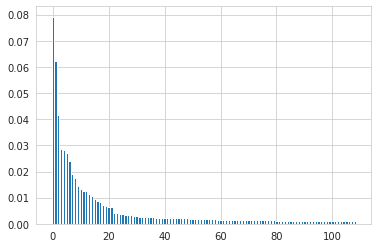

In [0]:
pca = PCA()
pca.fit(movie_vectors)
values = pca.explained_variance_ratio_[pca.explained_variance_ratio_>0.001]
plt.bar(np.arange(len(values)),values)

In [0]:
pca = PCA(n_components=150)
pca.fit(movie_vectors)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
movie_vectors = pca.transform(movie_vectors)

#Lista filmów per użytkownik

Należy teraz przetworzyć dane dotyczące ocen wystawionych przez użytkowków

Lista ocen poszczególnych jest najpierw sortowana malejąco po dacie wystawienia oceny - będzie to przydatne na etapie tworzenia rekomendacji

In [0]:
ratings_df_f= ratings_df.sort_values(by='timestamp', ascending=False,inplace=False)
inv_codes = {v: k for k, v in movie_codes.items()}
ratings_df_f['movieId'] = ratings_df_f['movieId'].map(inv_codes)

Dla każdego użytkownika zapisywane są dwa wektory zawierające id i oceny filmów.

Dla każdego filmu obliczana jest także średnia ocen użytkowników 

In [0]:
user_ratings = {}
for user_id, user_df in ratings_df_f.groupby('userId'):
  ratings = np.array(user_df['rating'])
  movies = np.array(user_df['movieId'])
  user_ratings[user_id]=np.array([movies,ratings])

movie_mean_ratings = np.zeros(len(movie_vectors))
for movie_id, movie_df in ratings_df_f.groupby('movieId'):
  ratings = np.array(movie_df['rating'])
  movie_mean_ratings[int(movie_id)] = np.sum(ratings)/len(ratings)

#Algorytm do znajdowania filmów

Algorytm wyszukiwania filmów odpowiednich dla danego użytkownika polega na znalezieniu wektorów leżących jak najbliżej filmów wysoko przez niego ocenionych.


##Obliczanie odległości

Za pomocą macierzy odległości znajdowana jest lista filmów leżących w pewnym określonym promieniu od filmów wysoko ocenionych przez użytkownika

In [0]:
def get_range_for_movie(movies, movie, max_dist):
  movie = np.array([movie])
  dists = (movies**2).sum(axis=1).reshape(-1,1) + (movie**2).sum(axis=1).reshape(1,-1) - 2*movies.dot(movie.T)
  closest = np.argsort(dists, axis=0)[1:].T
  dists = np.sort(dists, axis=0)[1:].T
  closest = closest[dists<= max_dist]
  dists = dists[dists<= max_dist]
  return closest, dists

W celu ustalenia odpowiedniej skali promienia, jednorazowo obliczana jest średnia maksymalna odległość, która pozwala na znalezienie conajmniej 25 filmów leżących w sąsiedztwie danego filmu.

In [0]:
def get_n_closest_dists(movies, users_movies, n=-1):
  dists = (movies**2).sum(axis=1).reshape(-1,1) + (users_movies**2).sum(axis=1).reshape(1,-1) - 2*movies.dot(users_movies.T)
  if n == -1:
    n = len(dists)  
  dists = np.sort(dists, axis=0)[:n].T
  return dists

max_dists = np.array([])
prev=0
for i in np.arange(5000,len(movie_vectors)+4999,5000):
  dists = get_n_closest_dists(movie_vectors,movie_vectors[prev:i],n=25)
  max_dists = np.append(max_dists,np.max(dists,axis=1).flatten())
  prev=i
mean_max = np.mean(max_dists)
mean_max

0.5894751401376662

##Tworzenie listy n rekomendacji

**Działanie właściwego algorytmu**

Ze słownika wczytywane są filmy, które otrzymały od użytkownika ocenę conajmniej 3 gwiazdek

Oceny są przemnażane przez wektor, który delikatnie zmniejsza je proporcjonalnie do czasu ich wystawienia. Dzięki temu nowe oceny, które bardziej oddają obecny gust użytkownika mają trochę większą wagę.

Z wagami proporcjonalnymi do oceny, losowana jest lista filmów, dla których obliczona zostanie lista sąsiadów. Lepiej oceniany film ma wiekszą szansę na zostanie wybranym

Następnie obliczana jest lista najbliżej leżących filmów, która jest filtrowana pod kątem już obejrzanych oraz średniej ocen innych użytkowników.
Jeśli jest na niej mniej niż n pozycji, rekurencyjnie zwracana jest lista dla dwa razy większego promienia.

W celu uniknięcia całkowitego determinizmu wyników, zamiast zwrócenia n najbliższych filmów, z listy pozycji leżących w danym promieniu losowane jest n elementów. Prawdopodobieństwo wylosowania określonego tytułu jest odwrotnie proporcjonalne do jego odległości oraz wprost proporcjonalne do jego średniej oceny,

In [0]:
def gen_n_best(n,user_id, rng=mean_max):
  ratings = user_ratings[user_id][1]
  movies = user_ratings[user_id][0][ratings>2.5]
  ratings = ratings[ratings>2.5]
  ratings = ratings*np.flip(np.logspace(-0.5,0,len(ratings),base=2))

  ps = ratings/sum(ratings)
  s_movies = np.random.choice(movies, size=n, replace=True, p=ps)

  r_list = []
  u, cn = np.unique(s_movies,return_counts=True)
  for m, c in zip(u,cn):
    closest, dists = get_range_for_movie(movie_vectors,movie_vectors[int(m)],max_dist=rng)
    unseen = np.logical_not(np.isin(closest,user_ratings[user_id][0]))
    closest = closest[unseen]
    dists = dists[unseen]
    mean_ratings = movie_mean_ratings[closest]
    closest = closest[mean_ratings>2.5]
    dists = dists[mean_ratings>2.5]
    mean_ratings = mean_ratings[mean_ratings>2.5]
    if len(closest) < n:
      return gen_n_best(n,user_id, 2*rng)
    probabilities = mean_ratings/np.abs((dists+1E-23))
    probabilities = probabilities/np.sum(probabilities)
    r_list.extend(np.random.choice(closest,size=c,replace=False,p=probabilities))
  return r_list


#Wyświetlanie rekomendacji
Proste metody do wizualizacji rekomendacji wygenerowanych dla danego użytkownika wraz z listą filmów ostatnio przez niego ocenionych

In [0]:
def get_movie_info(movieKey):
  movie_id = movie_codes[movieKey]
  info = movies_df[movies_df['movieId']==movie_id]
  return np.array([movie_id,info['title'].values[0],info['genres'].values[0]])

In [0]:
def print_recommendations(user_id):
  print("______________________")
  print("ID użytkownika: %d"%(user_id))
  print("----- Ostatnio wysoko ocenione filmy -----")
  for m,r in zip(user_ratings[user_id][0][:20],user_ratings[user_id][1][:20]):
    if r>3:
      info = get_movie_info(m)
      print(info[1],info[2],r)
  print("----- Rekomendacje -----")
  for i in gen_n_best(20,user_id):
    info = get_movie_info(i)
    print(info[1],info[2])

#Rekomendacje dla 1000 losowych użytkowników
Aby ocenić jakość rekomendacji wygenerowane zostaną one dla 1000 losowych użytkowników.

Muszą być one zapisane do pliku, ponieważ jednoczesne przechowywanie w pamięci danych dla generatora i algorytmu weryfikującego przekracza możliwości Google Colab

In [0]:
users = np.random.choice(len(user_ratings),size=1000,replace=False)
with open("recommendations.txt",'w') as f:
  for u in users:
    for i in gen_n_best(20,u):
      print(u,movie_codes[i],file=f)

#Surprise
W celu weryfikacji działania algorytmu, użyta zostanie biblioteka Surprise oferująca implementacje wielu algorytmów rekomendujących.

Umożliwia ona przewidywanie prawdopodobnej oceny filmu przez danego użytkownika na podstawie analizy innych jego ocen oraz ocen innych użytkowników.

Miarą słuszności rekomendacji będzie średnia przewidywana ocena polecanych filmów oraz rozkład przewidywanych ocen.


##Wczytywanie danych

In [0]:
!pip install surprise

In [0]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

In [0]:
reader = Reader(rating_scale=(0.5, 5))
ratings_df = pd.read_csv("/content/mydrive/dataMining/movie_lens/ratings.csv")
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
ratings_df = None

In [0]:
trainset = data.build_full_trainset()
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)

Estimating biases using als...


In [0]:
ratings = []
with open('recommendations.txt','r') as file:
  for line in file:
    line = line.split()
    ratings.append(algo.predict(int(line[0]),int(line[1]))[3])

##Wyniki
Przewidywane wartości zostaną zaokrąglone do najbliższej oceny 

Średnia przewidywana ocena polecanych filmów według Surprise wyniesie: 3.581693


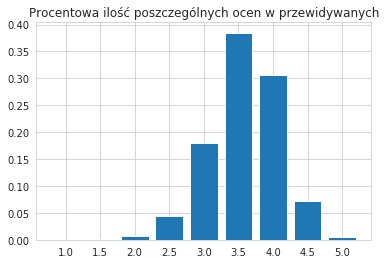

In [0]:
print("Średnia przewidywana ocena polecanych filmów według Surprise wyniesie: %f"%(np.mean(ratings)))
rounded = np.round(np.array(ratings)*2)/2
rates, counts = np.unique(rounded, return_counts=True)
counts = counts/np.sum(counts)
plt.bar(rates.astype(str),counts)
plt.title('Procentowa ilość poszczególnych ocen w przewidywanych')
plt.show()

#Wnioski

##Ocena wyników

Wyniki testu rekomendacji za pomocą biblioteki Surprise pokazują, że skuteczność algorytmu można uznać za zadowalającą.

Dla wylosowanej próbki 1000 rekomendacji:
- Średnia przewidywana ocena wynosi ponad 3.5 gwiazdki, co można uznać za ocenę pozytywną
- Ponad 90% z polecanych filmów według przewidywań powinno dostać od użytkownika ocenę nie niższą niż 3 gwiazdki
- Około 75% zostanie ocenione na conajmniej 3.5 gwiazdki
- Ponad 35% filmów otrzyma ocenę wyższą lub równą 4 gwiazdkom

##Możliwości rozwoju

W wielu miejscach implementacja algorytmu opiera się na dość naiwnych miarach i rozwiązaniach, takich jak proporcjonalność prawdopodobieństwa do odległości i oceny czy skalowanie ocen za pomocą funkcji wykładniczej. 

W celu zmaksymalizowania efektywności algorytmu dobrym pomysłem byłaby wnikliwa analiza poszczególnych problemów i dobranie miar dających jak najlepsze wyniki.

Oprócz tego algorytm w obecnej wersji zwraca wyłącznie listę rekomendowanych filmów. W jego implementacji jest jednak miejsce również na przewidywanie oceny użytkownika tak jak ma to miejsce w bibliotece Surprise.